In [1]:
import numpy as np 
import pandas as pd 
import os
import re
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, UpSampling2D, add
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

In [2]:
base_directory = '/home/mrrahul/code/prad/auto-encoder-project/'
hires_folder = os.path.join(base_directory, 'high res')
lowres_folder = os.path.join(base_directory, 'low res')

In [3]:
data = pd.read_csv("image_data.csv")
data['low_res'] = data['low_res'].apply(lambda x: os.path.join(lowres_folder,x))
data['high_res'] = data['high_res'].apply(lambda x: os.path.join(hires_folder,x))
data.head()

,low_res,high_res
0,/home/mrrahul/code/prad/auto-encoder-project/l...,/home/mrrahul/code/prad/auto-encoder-project/h...
1,/home/mrrahul/code/prad/auto-encoder-project/l...,/home/mrrahul/code/prad/auto-encoder-project/h...
2,/home/mrrahul/code/prad/auto-encoder-project/l...,/home/mrrahul/code/prad/auto-encoder-project/h...
3,/home/mrrahul/code/prad/auto-encoder-project/l...,/home/mrrahul/code/prad/auto-encoder-project/h...
4,/home/mrrahul/code/prad/auto-encoder-project/l...,/home/mrrahul/code/prad/auto-encoder-project/h...


In [4]:
batch_size = 4

image_datagen = ImageDataGenerator(rescale=1./255,validation_split=0.15)
mask_datagen = ImageDataGenerator(rescale=1./255,validation_split=0.15)

train_hiresimage_generator = image_datagen.flow_from_dataframe(
        data,
        x_col='high_res',
        target_size=(800, 1200),
        class_mode = None,
        batch_size = batch_size,
        seed=42,
        subset='training')

train_lowresimage_generator = image_datagen.flow_from_dataframe(
        data,
        x_col='low_res',
        target_size=(800, 1200),
        class_mode = None,
        batch_size = batch_size,
        seed=42,
        subset='training')

val_hiresimage_generator = image_datagen.flow_from_dataframe(
        data,
        x_col='high_res',
        target_size=(800, 1200),
        class_mode = None,
        batch_size = batch_size,
        seed=42,
        subset='validation')

val_lowresimage_generator = image_datagen.flow_from_dataframe(
        data,
        x_col='low_res',
        target_size=(800, 1200),
        class_mode = None,
        batch_size = batch_size,
        seed=42,
        subset='validation')

val_lowresimage_generator = image_datagen.flow_from_dataframe(
        data,
        x_col='low_res',
        target_size=(800, 1200),
        class_mode = None,
        batch_size = batch_size,
        seed=42,
        subset='validation')

train_generator = zip(train_lowresimage_generator, train_hiresimage_generator)
val_generator = zip(val_lowresimage_generator, val_hiresimage_generator)

def imageGenerator(train_generator):
    for (low_res, hi_res) in train_generator:
            yield (low_res, hi_res)

Found 3198 validated image filenames.
Found 3198 validated image filenames.
Found 564 validated image filenames.
Found 564 validated image filenames.
Found 564 validated image filenames.


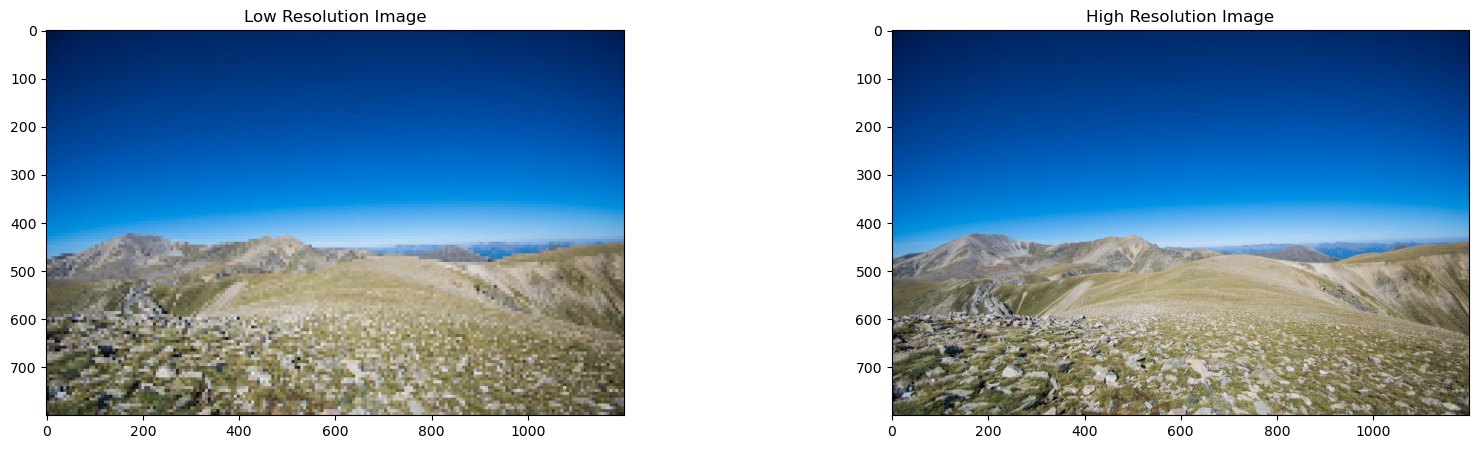

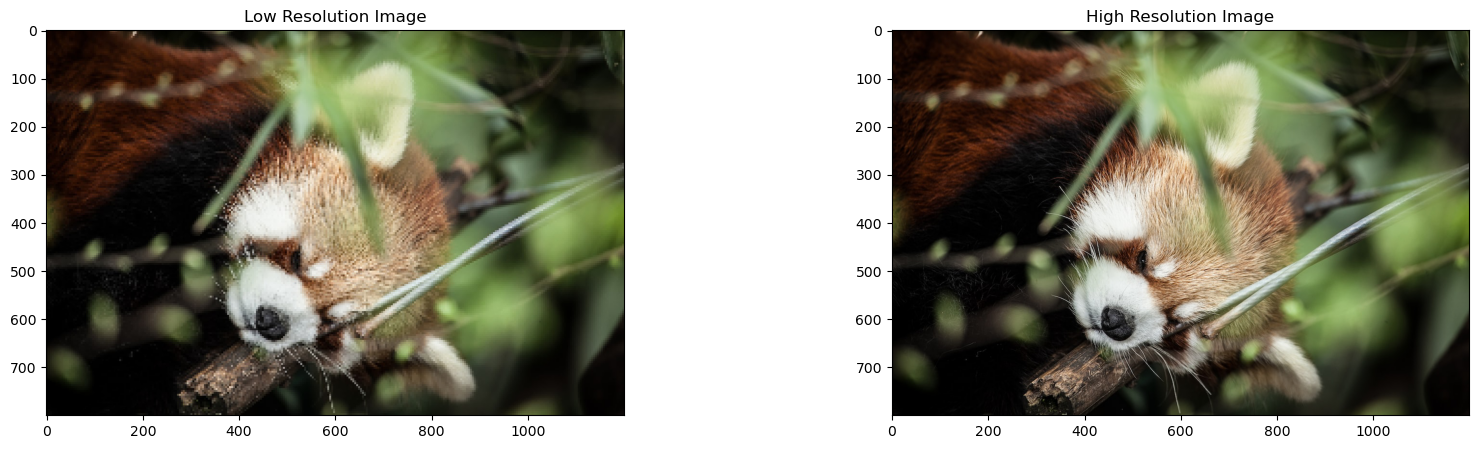

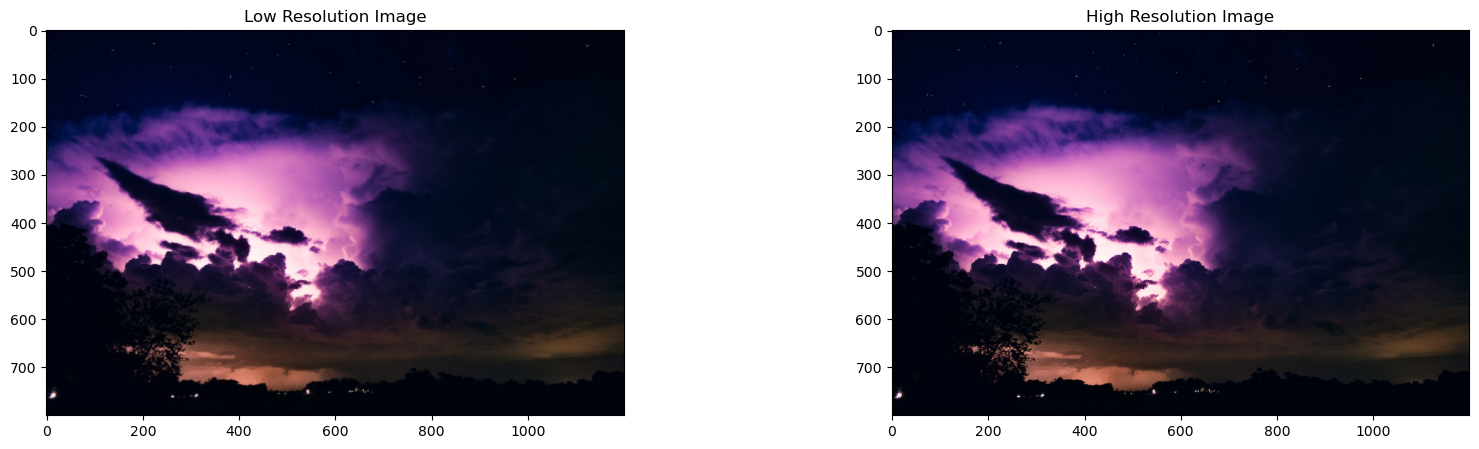

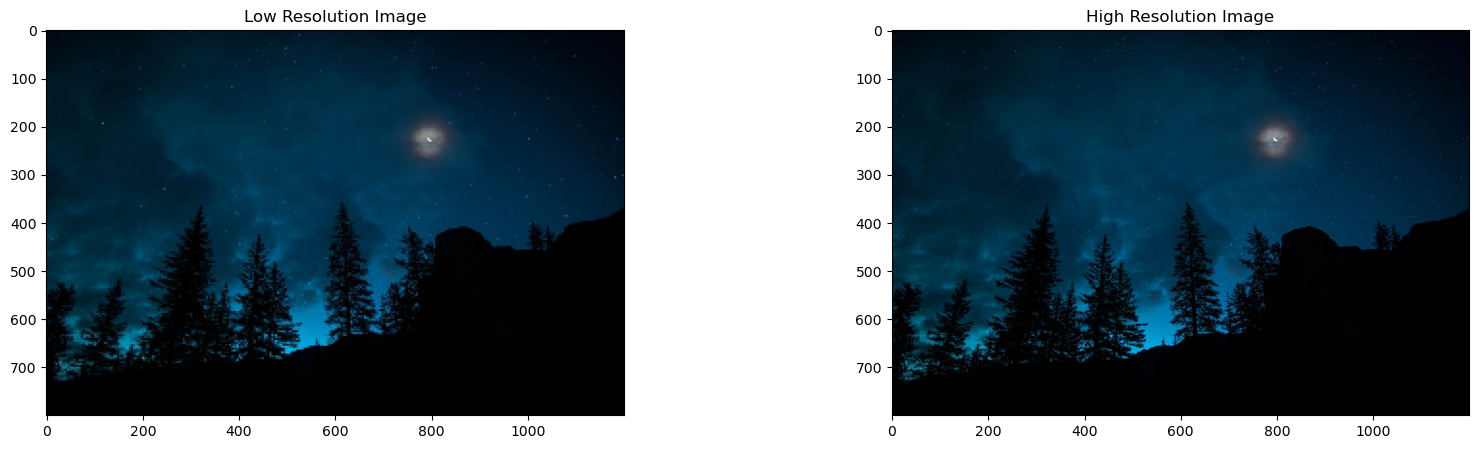

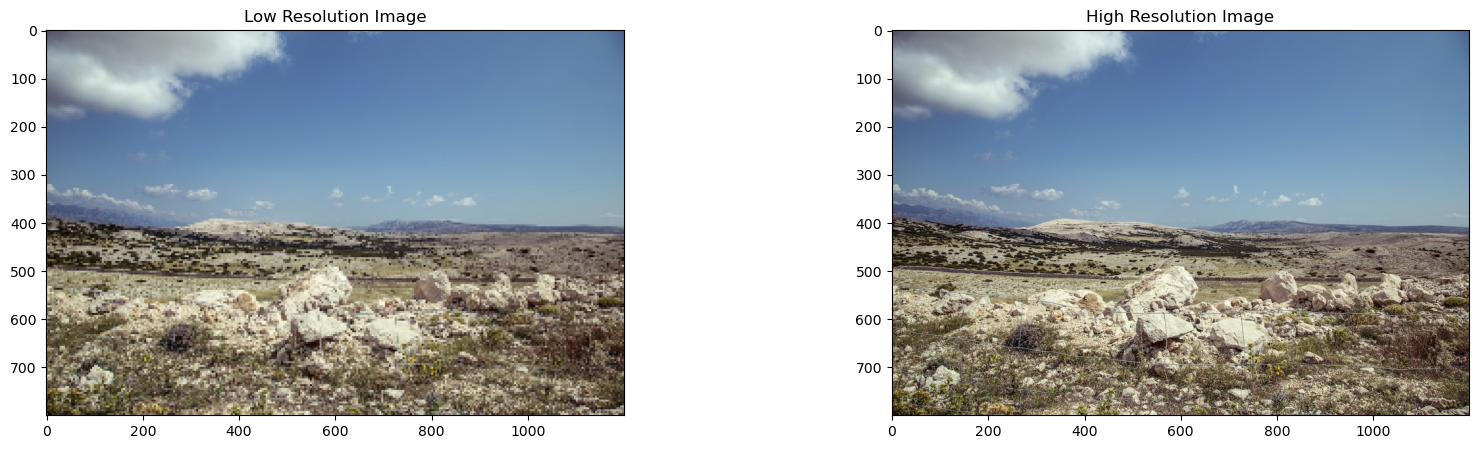

In [5]:
n = 0
for i,m in train_generator:
    img,out = i,m

    if n < 5:
        fig, axs = plt.subplots(1 , 2, figsize=(20,5))
        axs[0].imshow(img[0])
        axs[0].set_title('Low Resolution Image')
        axs[1].imshow(out[0])
        axs[1].set_title('High Resolution Image')
        plt.show()
        n+=1
    else:
        break

In [6]:
input_img = Input(shape=(800, 1200, 3))

l1 = Conv2D(64, (3, 3), padding='same', activation='relu')(input_img)
l2 = Conv2D(64, (3, 3), padding='same', activation='relu')(l1)
l3 = MaxPooling2D(padding='same')(l2)
l3 = Dropout(0.3)(l3)
l4 = Conv2D(128, (3, 3),  padding='same', activation='relu')(l3)
l5 = Conv2D(128, (3, 3), padding='same', activation='relu')(l4)
l6 = MaxPooling2D(padding='same')(l5)
l7 = Conv2D(256, (3, 3), padding='same', activation='relu')(l6)

l8 = UpSampling2D()(l7)

l9 = Conv2D(128, (3, 3), padding='same', activation='relu')(l8)
l10 = Conv2D(128, (3, 3), padding='same', activation='relu')(l9)

l11 = add([l5, l10])
l12 = UpSampling2D()(l11)
l13 = Conv2D(64, (3, 3), padding='same', activation='relu')(l12)
l14 = Conv2D(64, (3, 3), padding='same', activation='relu')(l13)

l15 = add([l14, l2])

decoded = Conv2D(3, (3, 3), padding='same', activation='relu')(l15)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])


2024-04-15 13:31:08.830039: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
autoencoder.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 800, 1200, 3 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 800, 1200, 64 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 800, 1200, 64 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 400, 600, 64) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [8]:


train_samples = train_hiresimage_generator.samples
val_samples = val_hiresimage_generator.samples

train_img_gen = imageGenerator(train_generator)
val_image_gen = imageGenerator(val_generator)



In [9]:
model_path = "autoencoder.h5"
checkpoint = ModelCheckpoint(model_path,
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 9,
                          verbose = 1,
                          restore_best_weights = True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=5, 
                                            verbose=1, 
                                            factor=0.2, 
                                            min_lr=0.00000001)

In [10]:


hist = autoencoder.fit(train_img_gen,
                    steps_per_epoch=train_samples//batch_size,
                    validation_data=val_image_gen,
                    validation_steps=val_samples//batch_size,
                    epochs=10, callbacks=[earlystop, checkpoint, learning_rate_reduction])



2024-04-15 13:31:09.311764: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2024-04-15 13:31:09.312752: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2095935000 Hz


Epoch 1/10


2024-04-15 13:31:16.398895: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1966080000 exceeds 10% of free system memory.
2024-04-15 13:31:20.339494: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 2211840000 exceeds 10% of free system memory.
2024-04-15 13:31:20.339494: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 2211840000 exceeds 10% of free system memory.
2024-04-15 13:31:38.502415: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 2211840000 exceeds 10% of free system memory.
2024-04-15 13:31:38.510593: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 2211840000 exceeds 10% of free system memory.
